In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x
!pip install -q keras-vggface
!pip install -q scikit-image
!pip install -q pydot
!pip install -q keras==2.2.5
!pip install h5py==2.10.0  

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.2.5


In [ ]:
EPOCHS = 50
BS = 64
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)
mfile = '/content/drive/MyDrive/aml/saved/resnet/my_best_model.epoch{epoch:02d}-loss{val_loss:.3f}.hdf5'
msave = keras.callbacks.ModelCheckpoint(filepath=mfile,verbose=1, save_weights_only=True,period= 10 )

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/train.zip' -d train

! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/test-public.zip' -d dev

! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/test-private.zip' -d test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=100,

    callbacks=[rlrop,msave]
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
448/448 [==============================] - 326s 727ms/step - loss: 1.9836 - acc: 0.3539 - val_loss: 1.2741 - val_acc: 0.5159
Epoch 2/100
448/448 [==============================] - 314s 702ms/step - loss: 1.3503 - acc: 0.4946 - val_loss: 1.1477 - val_acc: 0.5790
Epoch 3/100
448/448 [==============================] - 314s 701ms/step - loss: 1.2360 - acc: 0.5378 - val_loss: 1.0774 - val_acc: 0.6045
Epoch 4/100
448/448 [==============================] - 315s 702ms/step - loss: 1.1703 - acc: 0.5614 - val_loss: 1.0900 - val_acc: 0.5852
Epoch 5/100
448/448 [==============================] - 314s 701ms/step - loss: 1.1293 - acc: 0.5763 - val_loss: 1.0303 - val_acc: 0.6278
Epoch 6/100
448/448 [==============================] - 314s 701ms/step - loss: 1.0931 - acc: 0.5926 - val_loss: 1.0304 - val_acc: 0.6281
Epoch 7/100
448/448 [==============================] - 314s 702ms/step - loss: 1.0

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/saved/resnet/my_best_model.epoch20-loss14.156.hdf5')

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=70,
    callbacks=[rlrop,msave]
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
448/448 [==============================] - 320s 715ms/step - loss: 14.3416 - acc: 0.1102 - val_loss: 14.2607 - val_acc: 0.1152
Epoch 2/70
448/448 [==============================] - 310s 691ms/step - loss: 14.3340 - acc: 0.1107 - val_loss: 14.2479 - val_acc: 0.1160
Epoch 3/70
448/448 [==============================] - 306s 683ms/step - loss: 14.3384 - acc: 0.1104 - val_loss: 14.2479 - val_acc: 0.1160
Epoch 4/70
448/448 [==============================] - 307s 684ms/step - loss: 14.3358 - acc: 0.1106 - val_loss: 14.2845 - val_acc: 0.1138
Epoch 5/70
448/448 [==============================] - 305s 681ms/step - loss: 14.3403 - acc: 0.1103 - val_loss: 14.2159 - val_acc: 0.1180
Epoch 6/70
448/448 [==============================] - 305s 680ms/step - loss: 14.3456 - acc: 0.1100 - val_loss: 14.2388 - val_acc: 0.1166
Epoch 7/70
448/448 [==============================] - 303s 677ms/step - loss

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/saved/resnet/my_best_model.epoch60-loss14.271.hdf5')

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=40,
    callbacks=[rlrop,msave]
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
448/448 [==============================] - 614s 1s/step - loss: 14.3382 - acc: 0.1104 - val_loss: 14.2562 - val_acc: 0.1155
Epoch 2/40
448/448 [==============================] - 596s 1s/step - loss: 14.3368 - acc: 0.1105 - val_loss: 14.2434 - val_acc: 0.1163
Epoch 3/40
448/448 [==============================] - 595s 1s/step - loss: 14.3409 - acc: 0.1103 - val_loss: 14.2388 - val_acc: 0.1166
Epoch 4/40
448/448 [==============================] - 595s 1s/step - loss: 14.3381 - acc: 0.1104 - val_loss: 14.2662 - val_acc: 0.1149
Epoch 5/40
448/448 [==============================] - 595s 1s/step - loss: 14.3317 - acc: 0.1108 - val_loss: 14.2571 - val_acc: 0.1155
Epoch 6/40
448/448 [==============================] - 596s 1s/step - loss: 14.3419 - acc: 0.1102 - val_loss: 14.2799 - val_acc: 0.1140
Epoch 7/40
448/448 [==============================] - 596s 1s/step - loss: 14.3328 - acc: 0.11

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/saved/resnet/my_best_model.epoch90-loss14.193.hdf5')

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=10,
    callbacks=[rlrop,msave]
) 



Epoch 1/10
448/448 [==============================] - 480s 1s/step - loss: 14.3357 - acc: 0.1106 - val_loss: 14.2517 - val_acc: 0.1158
Epoch 2/10
448/448 [==============================] - 463s 1s/step - loss: 14.3402 - acc: 0.1103 - val_loss: 14.2571 - val_acc: 0.1155
Epoch 3/10
448/448 [==============================] - 462s 1s/step - loss: 14.3372 - acc: 0.1105 - val_loss: 14.2708 - val_acc: 0.1146
Epoch 4/10
448/448 [==============================] - 462s 1s/step - loss: 14.3391 - acc: 0.1104 - val_loss: 14.2434 - val_acc: 0.1163
Epoch 5/10
448/448 [==============================] - 462s 1s/step - loss: 14.3333 - acc: 0.1107 - val_loss: 14.2571 - val_acc: 0.1155
Epoch 6/10
448/448 [==============================] - 462s 1s/step - loss: 14.3318 - acc: 0.1108 - val_loss: 14.2342 - val_acc: 0.1169
Epoch 7/10
448/448 [==============================] - 462s 1s/step - loss: 14.3405 - acc: 0.1103 - val_loss: 14.2937 - val_acc: 0.1132
Epoch 8/10
448/448 [==============================] -

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/MyDrive/aml/models/' + 'RESNET50' + epoch_str + test_acc + '.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/models/RESNET50-EPOCHS_50test_acc_0.116.h5')

In [ ]:
results_dev = model.evaluate_generator(dev_generator, 3589 // BS)
print('dev loss:', results_dev[0],", dev acc:", results_dev[1])

dev loss: 14.251742124557495 , dev acc: 0.11579241071428571


In [ ]:
results_test = model.evaluate_generator(test_generator, 3599 // BS)
print('test loss:', results_test[0],", test acc:", results_test[1])

test loss: 14.251742175647191 , test acc: 0.11579241071428571


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


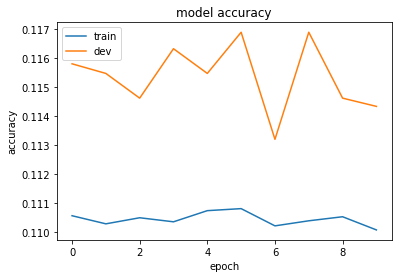

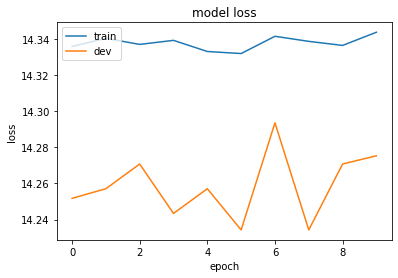

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()